In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
bitco=pd.read_csv("coin_Bitcoin.csv")
bitco.head()

,SNo,Name,Symbol,Date,High,Low,Open,Close,Volume,Marketcap
0,1,Bitcoin,BTC,2013-04-29 23:59:59,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
1,2,Bitcoin,BTC,2013-04-30 23:59:59,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2,3,Bitcoin,BTC,2013-05-01 23:59:59,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
3,4,Bitcoin,BTC,2013-05-02 23:59:59,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
4,5,Bitcoin,BTC,2013-05-03 23:59:59,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [3]:
bitco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2991 entries, 0 to 2990
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SNo        2991 non-null   int64  
 1   Name       2991 non-null   object 
 2   Symbol     2991 non-null   object 
 3   Date       2991 non-null   object 
 4   High       2991 non-null   float64
 5   Low        2991 non-null   float64
 6   Open       2991 non-null   float64
 7   Close      2991 non-null   float64
 8   Volume     2991 non-null   float64
 9   Marketcap  2991 non-null   float64
dtypes: float64(6), int64(1), object(3)
memory usage: 233.8+ KB


In [4]:
training_ratio = 80
test_ratio = 100-training_ratio

train_len = round(len(bitco)*(training_ratio/100))
test_len = round(len(bitco)-train_len)

ds_train = bitco.tail(train_len)
ds_test = bitco.head(test_len)

print("Shape Of Training Set :", ds_train.shape)
print("Shape Of Test Set :", ds_test.shape)

Shape Of Training Set : (2393, 10)
Shape Of Test Set : (598, 10)


In [5]:
ds_train['Date'] = pd.to_datetime(ds_train['Date'])

<ipython-input-5-35904b1fac8f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_train['Date'] = pd.to_datetime(ds_train['Date'])


In [6]:
ds_train.set_index('Date', inplace = True)

In [7]:
ds_train.sort_values(by='Date',ascending=True, inplace = True)

<ipython-input-7-647ee63c9263>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_train.sort_values(by='Date',ascending=True, inplace = True)


In [8]:
ds_train.head()

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2014-12-18 23:59:59,599,Bitcoin,BTC,323.709015,304.231995,319.785004,311.395996,39173000.0,4.241891e+09
2014-12-19 23:59:59,600,Bitcoin,BTC,318.532990,306.769012,311.178986,317.842987,23823100.0,4.330802e+09
2014-12-20 23:59:59,601,Bitcoin,BTC,330.325012,316.044006,317.618988,329.955994,20856700.0,4.496946e+09
2014-12-21 23:59:59,602,Bitcoin,BTC,329.628998,318.903015,329.542999,320.842987,15207600.0,4.373820e+09
2014-12-22 23:59:59,603,Bitcoin,BTC,334.117004,320.424988,321.067993,331.885986,22315100.0,4.525705e+09


In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))

def bit_pre_process(raw_data , seq_len, column = 1):
  
  data = raw_data.iloc[:, column].values
  data = data.reshape(-1, 1)
  
  data = sc.fit_transform(data)
  
  
  X = []
  y = []

  for i in range(seq_len, len(data)):
      X.append(data[i-seq_len:i, 0])
      y.append(data[i, 0])
  X, y = np.array(X), np.array(y)

  X = np.reshape(X, (X.shape[0], X.shape[1], 1))
  
  return X, y

In [10]:
sequence_length = 60
comumn_index= 3

X_train, y_train = bit_pre_process(ds_train , sequence_length, comumn_index)

In [11]:
print(X_train.shape)
print(y_train.shape)

(2333, 60, 1)
(2333,)


In [17]:

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, CuDNNLSTM
from keras.layers import Dropout

#Initialising the RNN
regressor = Sequential()

#Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

#Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

#Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#Adding the output layer
regressor.add(Dense(units = 1))

In [18]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mse', 'mae'])

In [19]:
regressor.fit(X_train, y_train, epochs = 50, batch_size = 50)

Epoch 1/50
47/47 [==============================] - 23s 193ms/step - loss: 0.0072 - mse: 0.0072 - mae: 0.0479
Epoch 2/50
47/47 [==============================] - 9s 188ms/step - loss: 0.0023 - mse: 0.0023 - mae: 0.0237
Epoch 3/50
47/47 [==============================] - 9s 189ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0219
Epoch 4/50
47/47 [==============================] - 9s 188ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0210
Epoch 5/50
47/47 [==============================] - 9s 187ms/step - loss: 0.0019 - mse: 0.0019 - mae: 0.0233
Epoch 6/50
47/47 [==============================] - 9s 188ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0213
Epoch 7/50
47/47 [==============================] - 9s 187ms/step - loss: 0.0018 - mse: 0.0018 - mae: 0.0240
Epoch 8/50
47/47 [==============================] - 9s 188ms/step - loss: 0.0014 - mse: 0.0014 - mae: 0.0198
Epoch 9/50
47/47 [==============================] - 9s 188ms/step - loss: 0.0013 - mse: 0.0013 - mae: 0.0193
Epoch 10/50
47/47 

In [20]:
ds_test['Date'] = pd.to_datetime(ds_test['Date'])

ds_test.set_index('Date', inplace = True)

ds_test.sort_values(by='Date',ascending=True, inplace = True)
ds_test.head()

<ipython-input-20-306b554fa805>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_test['Date'] = pd.to_datetime(ds_test['Date'])
<ipython-input-20-306b554fa805>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_test.sort_values(by='Date',ascending=True, inplace = True)


,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2013-04-29 23:59:59,1,Bitcoin,BTC,147.488007,134.000000,134.444000,144.539993,0.0,1.603769e+09
2013-04-30 23:59:59,2,Bitcoin,BTC,146.929993,134.050003,144.000000,139.000000,0.0,1.542813e+09
2013-05-01 23:59:59,3,Bitcoin,BTC,139.889999,107.720001,139.000000,116.989998,0.0,1.298955e+09
2013-05-02 23:59:59,4,Bitcoin,BTC,125.599998,92.281898,116.379997,105.209999,0.0,1.168517e+09
2013-05-03 23:59:59,5,Bitcoin,BTC,108.127998,79.099998,106.250000,97.750000,0.0,1.085995e+09


In [21]:
test_set = pd.concat((ds_train.tail(sequence_length), ds_test), axis = 0)
test_set.head(10)

,SNo,Name,Symbol,High,Low,Open,Close,Volume,Marketcap
Date,,,,,,,,,
2021-05-08 23:59:59,2932,Bitcoin,BTC,59464.612493,56975.210653,57352.765953,58803.775809,6.538298e+10,1.099864e+12
2021-05-09 23:59:59,2933,Bitcoin,BTC,59210.881789,56482.003545,58877.388698,58232.316142,6.590669e+10,1.089245e+12
2021-05-10 23:59:59,2934,Bitcoin,BTC,59519.354426,54071.455379,58250.872531,55859.797545,7.177655e+10,1.044927e+12
2021-05-11 23:59:59,2935,Bitcoin,BTC,56872.544921,54608.652459,55847.241042,56704.573058,6.130840e+10,1.060791e+12
2021-05-12 23:59:59,2936,Bitcoin,BTC,57939.362415,49150.533875,56714.533167,49150.533875,7.521540e+10,9.195278e+11
2021-05-13 23:59:59,2937,Bitcoin,BTC,51330.843586,46980.018752,49735.432065,49716.191603,9.672115e+10,9.301610e+11
2021-05-14 23:59:59,2938,Bitcoin,BTC,51438.119085,48868.578286,49682.981856,49880.533420,5.573750e+10,9.332769e+11
2021-05-15 23:59:59,2939,Bitcoin,BTC,50639.665328,46664.141871,49855.494650,46760.186561,5.916105e+10,8.749310e+11
2021-05-16 23:59:59,2940,Bitcoin,BTC,49720.044622,43963.350186,46716.637988,46456.058474,6.404787e+10,8.692791e+11


In [22]:
test_set.shape

(658, 9)

In [23]:
x_test, y_true = bit_pre_process(test_set , sequence_length, comumn_index)

In [24]:
predicted_stock_price = regressor.predict(x_test)

In [25]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)
real_stock_price = sc.inverse_transform(y_true.reshape(-1, 1))

In [26]:
def plot_predictions(real_price, predicted_price, title, x_label, y_label):
  plt.plot(real_price, color = 'green', label = 'Real Stock Price')
  plt.plot(predicted_price, color = 'red', label = 'Predicted Stock Price')
  plt.title(title)
  plt.xlabel('Time')
  plt.ylabel('Google Stock Price')
  plt.legend()
  plt.show()

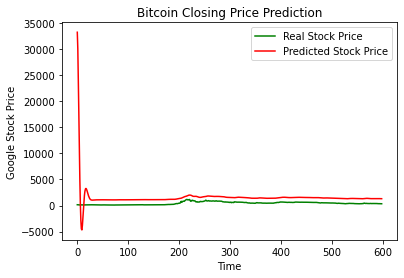

In [27]:
plot_predictions(real_stock_price, predicted_stock_price, "Bitcoin Closing Price Prediction", "Time", "Closing Price")

In [28]:
ds_test['Predicted_Close'] = predicted_stock_price
compare = ds_test[['Open','Close','Predicted_Close' ]]
compare.head(20)

<ipython-input-28-45dcbddaa3ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_test['Predicted_Close'] = predicted_stock_price


,Open,Close,Predicted_Close
Date,,,
2013-04-29 23:59:59,134.444000,144.539993,33261.750000
2013-04-30 23:59:59,144.000000,139.000000,30141.931641
2013-05-01 23:59:59,139.000000,116.989998,24559.992188
2013-05-02 23:59:59,116.379997,105.209999,17830.070312
2013-05-03 23:59:59,106.250000,97.750000,11050.013672
2013-05-04 23:59:59,98.099998,112.500000,5022.471680
2013-05-05 23:59:59,112.900002,115.910004,279.887817
2013-05-06 23:59:59,115.980003,112.300003,-2901.208008
2013-05-07 23:59:59,112.250000,111.500000,-4492.044434


In [29]:
def buy_sell(op, cl):
  
  if cl > op:    
    return 1 
  else:
    return 0

compare["Buy(Actual)"] = list(map(buy_sell, compare['Open'], compare['Close']))
compare["Buy(Predicted)"] = list(map(buy_sell, compare['Open'], compare['Predicted_Close']))

compare.tail()

<ipython-input-29-cf998f1346ec>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare["Buy(Actual)"] = list(map(buy_sell, compare['Open'], compare['Close']))
<ipython-input-29-cf998f1346ec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  compare["Buy(Predicted)"] = list(map(buy_sell, compare['Open'], compare['Predicted_Close']))


,Open,Close,Predicted_Close,Buy(Actual),Buy(Predicted)
Date,,,,,
2014-12-13 23:59:59,352.381012,347.376007,1318.055908,0,1
2014-12-14 23:59:59,346.726990,351.631989,1313.749146,1,1
2014-12-15 23:59:59,351.360992,345.345001,1310.077515,0,1
2014-12-16 23:59:59,345.673004,327.062012,1307.312500,0,1
2014-12-17 23:59:59,326.855011,319.776001,1305.265869,0,1


In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(compare['Buy(Actual)'], compare['Buy(Predicted)'])
Accuracy = cm.diagonal().sum()/cm.sum()
print("Buy or Sell Accuracy : ", Accuracy)

Buy or Sell Accuracy :  0.5083612040133779
